<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-pyresample-to-plot-channel-30-radiances" data-toc-modified-id="Use-pyresample-to-plot-channel-30-radiances-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use pyresample to plot channel 30 radiances</a></span></li><li><span><a href="#Read-the-lons/lats-from-the-MYD03-file" data-toc-modified-id="Read-the-lons/lats-from-the-MYD03-file-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read the lons/lats from the MYD03 file</a></span></li><li><span><a href="#get-the-map-projection-from-corners.json" data-toc-modified-id="get-the-map-projection-from-corners.json-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>get the map projection from corners.json</a></span></li><li><span><a href="#Use-pyresample-to-define-a-new-grid-in-this-projection" data-toc-modified-id="Use-pyresample-to-define-a-new-grid-in-this-projection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Use pyresample to define a new grid in this projection</a></span></li><li><span><a href="#resample-the-longitudes-on-this-grid" data-toc-modified-id="resample-the-longitudes-on-this-grid-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>resample the longitudes on this grid</a></span></li><li><span><a href="#replace-missing-values-with-floating-point-nan" data-toc-modified-id="replace-missing-values-with-floating-point-nan-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>replace missing values with floating point nan</a></span></li><li><span><a href="#Plot-the-image-using-cartopy" data-toc-modified-id="Plot-the-image-using-cartopy-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot the image using cartopy</a></span></li></ul></div>

# Use pyresample to plot channel 30 radiances

This notebook uses a MYD03 file and a modis_chans.hdf file to resample the channel 30 radiance
from your granule onto a laea projection.

The two files are copied to new files below called generic_m3 and generic_rad,
so that this notebook works for all granules.

In [1]:
import a301
import json
from a301.utils.data_read import download
import a301
import pprint
import shutil
from pyhdf.SD import SD, SDC
import json
import pprint
import cartopy
from pyresample import kd_tree
from a301.scripts.modismeta_read import parseMeta

read_data=False
if read_data:
    filename_M3='MYD03.A2013222.2105.006.2013223155808.hdf'
    download(filename_M3)
    for filename in [filename_M3,filename_M2]:
        local_file = Path.cwd() / Path(filename)
        to_file = a301.data_dir / Path(filename)
        print(f'copy {local_file} to {to_file}')
        shutil.copy(local_file,to_file)

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
from pathlib import Path
import pprint
import numpy as np
import pdb
import shutil
#

# Read the lons/lats from the MYD03 file



In [14]:
#
# this cell copies your files to the following generic files if they don't exist
#
generic_rad = a301.data_dir / Path('rad_file_2018_10_1.hdf')
generic_m3 = a301.data_dir / Path('m3_file_2018_10_1.hdf')
#
# put your MYD03 file and the file you get when you run 
# 
#
m3_file = a301.data_dir / Path('MYD03.A2013222.2105.006.2013223155808.hdf')
rad_file = a301.data_dir / Path('modis_chans_2018_9_24.hdf')


first_time=False
if first_time:
    #
    # you files are rad_file and m3_file
    # Note that you need to rerun modis_multichannel.ipynb 
    # to get modis_chans_2018_9_24.hdf
    #
    rad_file = a301.data_dir / Path('modis_chans_2018_9_24.hdf')
    m3_file = Path('MYD03.A2013222.2105.006.2013223155808.hdf')
    if generic_m3.is_file():
        raise ValueError(f'you already have {generic_m3}, need to move it')
    shutil.copy(m3_file,generic_m3)
    if generic_rad.is_file():
        raise ValueError(f'you already have {generic_rad}, need to move it')
    shutil.copy(rad_file,generic_rad)
    rad_file = SD(str(generic_rad), SDC.READ)
    rad_filename = rad_file.filename
    rad_file.end()
    print(f"\nworking with radiance file {generic_rad}\n"
          f"with original data {rad_filename}\n")
    m3_metadata=parseMeta(generic_m3)
    print(f"\nworking with m3_file {generic_m3} \n"
          f"with original data {m3_metadata['filename']}")

In [17]:
# Read the lats and lons from the MYD03 file
print(f'reading {generic_m3}')
m3_file = SD(str(generic_m3), SDC.READ)
lats = m3_file.select('Latitude').get()
lons = m3_file.select('Longitude').get()
m3_file.end()

reading /Users/phil/repos/a301_code/data/m3_file_2018_10_1.hdf


In [19]:
#Read ch30 from the generic_rad file
rad_file = SD(str(generic_rad), SDC.READ)
ch30 = rad_file.select('ch30').get()
rad_file.end()

# get the map projection from corners.json

Get the map  projection and extent from corners.json that were written
by cartopy_mapping_pyproject.ipynb

In [5]:
json_file = a301.data_dir / Path('corners.json')
with open(json_file,'r') as f:
    map_dict=json.load(f)
pprint.pprint(map_dict)

{'extent': [-1285873.5967137816,
            1561347.9917805532,
            -1179100.5032042824,
            1297248.5261361937],
 'lats': [32.13645206898284,
          28.687374622563773,
          45.73346985640787,
          50.510827489422674,
          32.13645206898284],
 'lons': [-104.77089390290801,
          -129.005397891393,
          -138.038848796623,
          -107.001718605882,
          -104.77089390290801],
 'proj4_params': {'datum': 'WGS84',
                  'ellps': 'WGS84',
                  'lat_0': 39.59910106367865,
                  'lon_0': -121.4048713497655,
                  'proj': 'laea',
                  'x_0': 0.0,
                  'y_0': 0.0},
 'proj4_string': '+datum=WGS84 +ellps=WGS84 +proj=laea '
                 '+lon_0=-121.4048713497655 +lat_0=39.59910106367865 +x_0=0.0 '
                 '+y_0=0.0 +no_defs',
 'xcoords': [1561347.9917805532,
             -744961.1366254934,
             -1285873.5967137816,
             1019738.9399581843,
   

# Use pyresample to define a new grid in this projection

In [6]:
from pyresample import load_area, save_quicklook, SwathDefinition
proj_params = map_dict['proj4_params']
swath_def = SwathDefinition(lons, lats)
area_def=swath_def.compute_optimal_bb_area(proj_dict=proj_params)

In [7]:
dir(area_def)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_projection_x_coords',
 '_projection_y_coords',
 'area_extent',
 'area_extent_ll',
 'area_id',
 'cartesian_coords',
 'colrow2lonlat',
 'corners',
 'create_areas_def',
 'create_areas_def_legacy',
 'crop_around',
 'crop_offset',
 'dtype',
 'get_area',
 'get_area_extent_for_subset',
 'get_area_slices',
 'get_bbox_lonlats',
 'get_boundary_lonlats',
 'get_cartesian_coords',
 'get_lonlat',
 'get_lonlats',
 'get_lonlats_dask',
 'get_proj_coords',
 'get_proj_coords_dask',
 'get_proj_vectors_dask',
 'get_xy_from_lonlat',
 'get_xy_from_proj_coords',
 'hash',
 'intersection',
 'lats',
 'lonlat2colro

# resample the longitudes on this grid

In [23]:
fill_value=-9999.
area_name = 'modis swath 5min granule'
image_30 = kd_tree.resample_nearest(swath_def, ch30.ravel(),
                                  area_def, radius_of_influence=5000, 
                                      nprocs=2,fill_value=fill_value)
print(f'\ndump area definition:\n{area_def}\n')
print((f'\nx and y pixel dimensions in meters:'
       f'\n{area_def.pixel_size_x}\n{area_def.pixel_size_y}\n'))


dump area definition:
Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'ellps': 'WGS84', 'lat_0': '39.59910106367865', 'lon_0': '-121.4048713497655', 'proj': 'laea', 'x_0': '0.0', 'y_0': '0.0'}
Number of columns: 1489
Number of rows: 2244
Area extent: (-1269560.846045296, -1177850.7780355075, 1532203.80246403, 1265820.4615973115)


x and y pixel dimensions in meters:
1881.641805580474
1088.980053312308



# replace missing values with floating point nan

In [24]:
nan_value = np.array([np.nan],dtype=np.float32)[0]
image_30[image_30< -9000]=nan_value

# Plot the image using cartopy

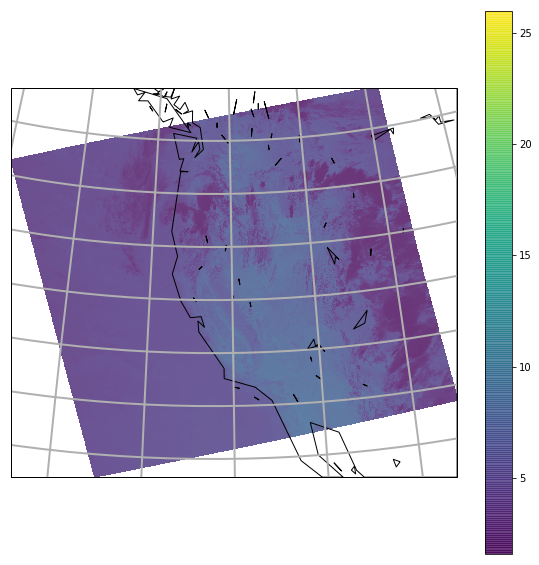

In [40]:
crs = area_def.to_cartopy_crs()
fig, ax = plt.subplots(1, 1, figsize=(10,10),
                          subplot_kw={'projection': crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale='coarse', levels=[1,2,3]));
ax.set_extent(crs.bounds,crs)
cs=ax.imshow(image_30, transform=crs, extent=crs.bounds, origin='upper',alpha=0.8)
fig.colorbar(cs);